In [153]:
import os
import h5py
import torch
import evoaug
import numpy as np
from evoaug import evoaug, augment
from evoaug_analysis import utils, model_zoo
import seqexplainer as se
import seqpro as sp

In [ ]:
output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/deepstarr"

# Load the model
The inputs are genomic sequences of length 249 nt and the output is 2 scalar values representing the activity of developmental enhancers and housekeeping enhancers measured experimentally using STARR-seq.

In [3]:
# Load the DeepSTARR model that was trained in the evo_aug paper
ckpt_path = "/cellar/users/aklie/projects/ML4GLand/models/deAlmeida22/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt"
deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = evoaug.RobustModel(deepstarr, 
                                 criterion=loss, 
                                 optimizer=optimizer_dict, 
                                 augment_list=[])

# load model weights
standard_cnn = evoaug.load_model_from_checkpoint(standard_cnn, ckpt_path).eval()

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file projects/ML4GLand/models/deAlmeida22/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt`


In [5]:
# Load in test data from the evo_aug paper, most likely will not need other than for testing
dataset = h5py.File("/cellar/users/aklie/data/ml4gland/pubs/deAlmeida22/evo_aug/DeepSTARR_data.h5", 'r')
x_test = np.array(dataset['X_test']).astype(np.float32)
y_test = np.array(dataset['Y_test']).astype(np.float32)
x_test.shape, y_test.shape

((41186, 4, 249), (41186, 2))

In [7]:
# Test the model on the first 10 sequences (developmental and housekeeping respectively)
standard_cnn(torch.tensor(x_test[:10], dtype=torch.float32))

tensor([[ 2.3393,  1.1384],
        [ 0.7076, -0.8634],
        [ 4.1096,  1.2375],
        [ 0.6293, -0.0113],
        [ 1.3934, -0.3355],
        [ 2.8418,  1.0122],
        [ 2.1076,  0.7741],
        [ 0.0710, -0.6417],
        [ 5.2085,  1.9021],
        [ 1.0811, -0.6353]], grad_fn=<AddmmBackward0>)

# Load motifs: ETS, SREBP, GATA, AP-1 and Dref
See Supplementary table 10 of the DeepSTARR paper for the motif IDs (parially listed below).
| TF motif | PWM model                                          | Collection name |
|----------|----------------------------------------------------|-----------------|
| AP-1     | jaspar__MA0476.1                                   | jaspar          |
| GATA     | flyfactorsurvey__srp_SANGER_5_FBgn0003507           | flyfactorsurvey |
| twist    | flyfactorsurvey__twi_da_SANGER_5_FBgn0000413        | flyfactorsurvey |
| Trl      | flyfactorsurvey__Trl_FlyReg_FBgn0013263             | flyfactorsurvey |
| SREBP    | flyfactorsurvey__HLH106_SANGER_10_FBgn0015234       | flyfactorsurvey |
| ETS      | flyfactorsurvey__Ets97D_SANGER_10_FBgn0004510       | flyfactorsurvey |
| Dref     | homer__AVYTATCGATAD_DREF                           | homer           |
| Ohler1   | homer__MYGGTCACACTG_Unknown1                       | homer           |
| Ohler6   | homer__AAAAATACCRMA_Unknown4                | homer           |

In [8]:
# We can use motifdata for the jaspar and homer motif databases
import motifdata as md

In [9]:
# From jaspar
ap1_motif = md.load_jaspar(motif_accs=["MA0476.1"])["MA0476.1"]
ap1_consensus = ap1_motif.consensus

In [10]:
# From flybase, had to do manual
gata_consensus = "TGATAAGG"
ets_consensus = "ACCGGAAGT"
srebp_consensus = "ATCACGCGAC"

In [11]:
# From homer
dref_motif = md.read_homer("/cellar/users/aklie/opt/homer/motifs/insects/dref.motif")["AVYTATCGATAD"]
dref_consensus = dref_motif.consensus

In [12]:
# Print out the consensus sequences
print(ap1_consensus)
print(gata_consensus)
print(ets_consensus)
print(srebp_consensus)
print(dref_consensus)

TGTGACTCATT
TGATAAGG
ACCGGAAGT
ATCACGCGAC
AACTATCGATAG


# Background sequences

# SeqExplainer function

In [322]:
from seqexplainer.gia._perturb import embed_pattern_seqs, tile_pattern_seqs

def embed_motifs_deepstarr(
    null_sequences,
    motif_a,
    motif_b,
    step=1,
    allow_overlap=False
):

    # center will have one more bp to the right if odd sequence length and even motif a length

    # Get the length of the motifs and sequences
    motif_a_len = len(motif_a)
    motif_b_len = len(motif_b)
    seq_len = len(null_sequences[0])
    
    # Grab the middle of the sequence and offset by the motif length so that the motif is centered
    motif_a_start = int(np.floor(seq_len/2) - np.ceil(motif_a_len/2))
    
    # Embed motif A in the sequence at the center
    A_seqs = embed_pattern_seqs(
        seqs=null_sequences,
        pattern=motif_a,
        positions=motif_a_start,
        ohe=False
    )

    # Get the positions that motif B will get tiled across
    motif_b_pos = np.arange(0, seq_len - motif_b_len + 1, step=step)
    
    # Remove any positions that overlap with motif A
    if not allow_overlap:
        
        # Remove any positions that overlap with motif A
        motif_b_pos = motif_b_pos[~((motif_b_pos >= (motif_a_start - motif_b_len)) & (motif_b_pos <= (motif_a_start + motif_a_len)))]
        
        # Tile B across the background
        B_seqs = []
        for pos in motif_b_pos:
            curr_B_seqs = embed_pattern_seqs(
                seqs=null_sequences,
                pattern=motif_b,
                positions=int(pos),
                ohe=False
            )
            B_seqs.append(curr_B_seqs)
        B_seqs = np.array(B_seqs)

        # Tile B across the A sequences
        AB_seqs = []
        for pos in motif_b_pos:
            curr_AB_seqs = embed_pattern_seqs(
                seqs=A_seqs,
                pattern=motif_b,
                positions=int(pos),
                ohe=False
            )
            AB_seqs.append(curr_AB_seqs)
        AB_seqs = np.array(AB_seqs)

    # Allow overlap
    else:
        
        # Tile the motif B across the sequence
        B_seqs = tile_pattern_seqs(
            seqs=null_sequences,
            pattern=motif_b,
            ohe=False,
            step=step
        )

        # Tile B across the A sequences
        AB_seqs = tile_pattern_seqs(
            seqs=A_seqs,
            pattern=motif_b,
            ohe=False,
            step=step
        )

    # Grab distances, turn into a string and add + for positive and - for negative
    motif_b_distances = (motif_b_pos - motif_a_start).astype(str)
    motif_b_distances = np.array(["+" + dist if int(dist) >= 0 else dist for dist in motif_b_distances])
    return A_seqs, B_seqs, AB_seqs, motif_b_pos, motif_b_distances

In [323]:
from seqexplainer.preprocess._preprocess import ohe_seqs
from seqexplainer._utils import _model_to_device
from tqdm.auto import tqdm

def deepstarr_motif_distance_cooperativity(
    model,
    b_seqs,
    A_seqs,
    B_seqs,
    AB_seqs,
    motif_b_distances,
    batch_size=128,
    device="cpu"
):
    # Put the model on the device
    _model_to_device(model, device)

    # Get b scores (background)
    print("Getting background scores")
    b_ohe = ohe_seqs(b_seqs, verbose=False)
    b_tensor = torch.tensor(b_ohe, dtype=torch.float32)
    b_scores = []
    for j in range(0, len(b_tensor), batch_size):
        curr_inputs = b_tensor[j:j+batch_size].to(device)
        b_scores.append(model(curr_inputs).detach().cpu().numpy())
    b_scores = np.concatenate(b_scores, axis=0)

    # Get motif A scores
    print("Getting motif A scores")
    A_ohe = ohe_seqs(A_seqs, verbose=False)
    A_tensor = torch.tensor(A_ohe, dtype=torch.float32)
    A_scores = []
    for j in range(0, len(A_tensor), batch_size):
        curr_inputs = A_tensor[j:j+batch_size].to(device)
        A_scores.append(model(curr_inputs).detach().cpu().numpy())
    A_scores = np.concatenate(A_scores, axis=0)

    d_median_fold_changes = {}
    for i, d in tqdm(enumerate(motif_b_distances), total=len(motif_b_distances), desc="Calculating median fold changes for each distance"):
        curr_B_seqs = B_seqs[i]
        curr_B_ohe = ohe_seqs(curr_B_seqs, verbose=False)
        curr_B_tensor = torch.tensor(curr_B_ohe, dtype=torch.float32)
        curr_B_scores = []
        for j in range(0, len(curr_B_tensor), batch_size):
            curr_inputs = curr_B_tensor[j:j+batch_size].to(device)
            curr_B_scores.append(model(curr_inputs).detach().cpu().numpy())
        curr_B_scores = np.concatenate(curr_B_scores)
        
        curr_AB_seqs = AB_seqs[i]
        curr_AB_ohe = ohe_seqs(curr_AB_seqs, verbose=False)
        curr_AB_tensor = torch.tensor(curr_AB_ohe, dtype=torch.float32)
        curr_AB_scores = []
        for j in range(0, len(curr_AB_tensor), batch_size):
            curr_inputs = curr_AB_tensor[j:j+batch_size].to(device)
            curr_AB_scores.append(model(curr_inputs).detach().cpu().numpy())
        curr_AB_scores = np.concatenate(curr_AB_scores)
        
        # Normalize
        b_exp = np.exp2(b_scores)
        A_exp = np.exp2(A_scores)
        curr_B_exp = np.exp2(curr_B_scores)
        curr_AB_exp = np.exp2(curr_AB_scores)

        # Get denom
        denom = A_exp + curr_B_exp - b_exp

        # Get fold change
        fold_change = curr_AB_exp / denom

        # Get median fold change
        median_fold_change = np.median(fold_change, axis=0)
        d_median_fold_changes[d] = median_fold_change

    return d_median_fold_changes

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

def deepstarr_cooperativity_plot(
    cooperativity_results,
    cols=["dev", "hk"],
    comparsion_name=None
):
    
    # Plot the results with the distance on the x-axis and the median fold change for both dev and hk on the y-axis, color by relative to motif a
    # Make the markers lines for dev and hk different and denote with a legend
    
    # Make a dataframe
    cooperativity_results = pd.DataFrame(cooperativity_results).T
    cooperativity_results["distance"] = [int(d[1:]) for d in cooperativity_results.index]
    cooperativity_results["relative_to_motif_a"] = [d[0] for d in cooperativity_results.index]
    cooperativity_results.rename(columns={0: "dev", 1: "hk"}, inplace=True)
    
    # Plot the results
    labels = []
    handles = []
    if "dev" in cols:
        sns.lineplot(
            data=cooperativity_results,
            x="distance",
            y="dev",
            hue="relative_to_motif_a",
            linestyle="-"
        )
        labels += ["Dev, +", "Dev, -"]
        handles += [
            Line2D([0], [0], color="orange", linestyle="-"),
            Line2D([0], [0], color="blue", linestyle="-")
        ]
    if "hk" in cols:
        sns.lineplot(
            data=cooperativity_results,
            x="distance",
            y="hk",
            hue="relative_to_motif_a",
            linestyle="--"
        )
        labels += ["HK, +", "HK, -"]
        handles += [
            Line2D([0], [0], color="orange", linestyle="--"),
            Line2D([0], [0], color="blue", linestyle="--")
        ]

    # Denote the dev vs hk lines styles and colors for the relative to motif a with a legend
    plt.legend(
        title=f"Relative to Motif A",
        loc="upper right",
        labels=labels,
        handles=handles
    )

    # Set the x-axis label to "Distance from motif B to motif A"
    plt.ylabel("Median DeepSTARR predicted cooperativity")
    plt.xlabel("Motif pair distance")
    if comparsion_name is not None:
        plt.title(comparsion_name)

    plt.show()

In [342]:
seq_number = 60
seq_len = 249

119
Getting background scores
Getting motif A scores


Calculating median fold changes for each distance:   0%|          | 0/220 [00:00<?, ?it/s]

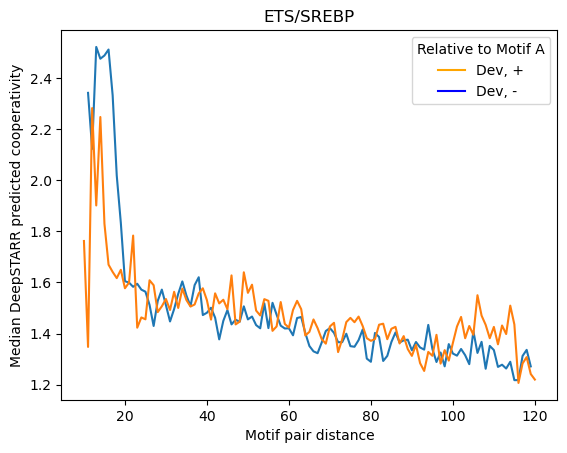

In [344]:
motif_a_name = "ETS"
motif_b_name = "SREBP"
motif_a = ets_consensus
motif_b = srebp_consensus
random_backbones = sp.random_seqs(seq_number, seq_len)

A_seqs, B_seqs, AB_seqs, motif_b_pos, motif_b_distances = embed_motifs_deepstarr(
    random_backbones,
    motif_a,
    motif_b,
    step=1
)

cooperativity_results = deepstarr_motif_distance_cooperativity(
    model=standard_cnn,
    b_seqs=random_backbones,
    A_seqs=A_seqs,
    B_seqs=B_seqs,
    AB_seqs=AB_seqs,
    motif_b_distances=motif_b_distances,
    batch_size=128,
    device="cuda"
)

deepstarr_cooperativity_plot(
    cooperativity_results=cooperativity_results,
    cols=["dev"],
    comparsion_name=f"{motif_a_name}/{motif_b_name}"
)

120
Getting background scores
Getting motif A scores


Calculating median fold changes for each distance:   0%|          | 0/225 [00:00<?, ?it/s]

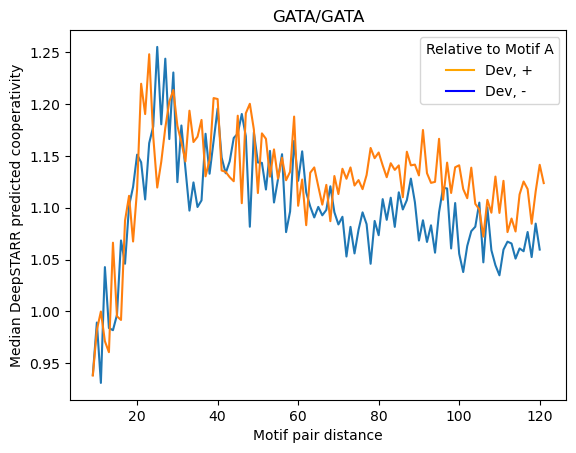

In [345]:
motif_a_name = "GATA"
motif_b_name = "GATA"
motif_a = gata_consensus
motif_b = gata_consensus
random_backbones = sp.random_seqs(seq_number, seq_len)

A_seqs, B_seqs, AB_seqs, motif_b_pos, motif_b_distances = embed_motifs_deepstarr(
    random_backbones,
    motif_a,
    motif_b,
    step=1
)

cooperativity_results = deepstarr_motif_distance_cooperativity(
    model=standard_cnn,
    b_seqs=random_backbones,
    A_seqs=A_seqs,
    B_seqs=B_seqs,
    AB_seqs=AB_seqs,
    motif_b_distances=motif_b_distances,
    batch_size=128,
    device="cuda"
)

deepstarr_cooperativity_plot(
    cooperativity_results=cooperativity_results,
    cols=["dev"],
    comparsion_name=f"{motif_a_name}/{motif_b_name}"
)

118
Getting background scores
Getting motif A scores


Calculating median fold changes for each distance:   0%|          | 0/222 [00:00<?, ?it/s]

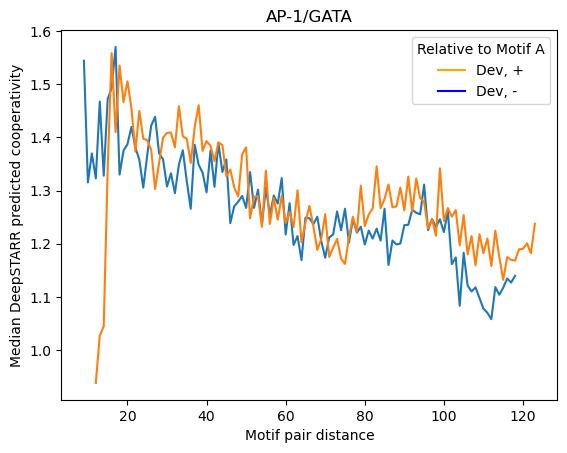

In [346]:
motif_a_name = "AP-1"
motif_b_name = "GATA"
motif_a = ap1_consensus
motif_b = gata_consensus
random_backbones = sp.random_seqs(seq_number, seq_len)

A_seqs, B_seqs, AB_seqs, motif_b_pos, motif_b_distances = embed_motifs_deepstarr(
    random_backbones,
    motif_a,
    motif_b,
    step=1
)

cooperativity_results = deepstarr_motif_distance_cooperativity(
    model=standard_cnn,
    b_seqs=random_backbones,
    A_seqs=A_seqs,
    B_seqs=B_seqs,
    AB_seqs=AB_seqs,
    motif_b_distances=motif_b_distances,
    batch_size=128,
    device="cuda"
)

deepstarr_cooperativity_plot(
    cooperativity_results=cooperativity_results,
    cols=["dev"],
    comparsion_name=f"{motif_a_name}/{motif_b_name}"
)

118
Getting background scores
Getting motif A scores


Calculating median fold changes for each distance:   0%|          | 0/213 [00:00<?, ?it/s]

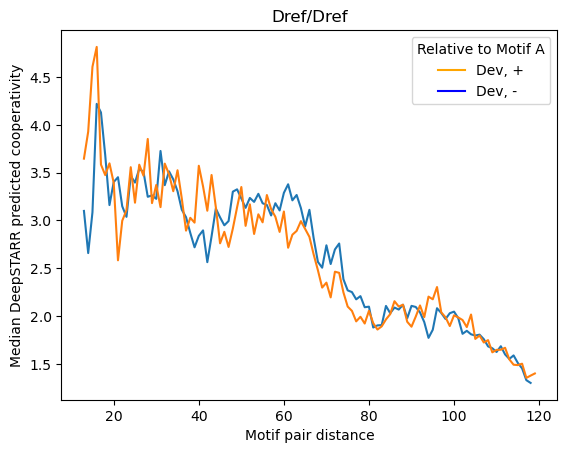

In [347]:
motif_a_name = "Dref"
motif_b_name = "Dref"
motif_a = dref_consensus
motif_b = dref_consensus
random_backbones = sp.random_seqs(seq_number, seq_len)

A_seqs, B_seqs, AB_seqs, motif_b_pos, motif_b_distances = embed_motifs_deepstarr(
    random_backbones,
    motif_a,
    motif_b,
    step=1
)

cooperativity_results = deepstarr_motif_distance_cooperativity(
    model=standard_cnn,
    b_seqs=random_backbones,
    A_seqs=A_seqs,
    B_seqs=B_seqs,
    AB_seqs=AB_seqs,
    motif_b_distances=motif_b_distances,
    batch_size=128,
    device="cuda"
)

deepstarr_cooperativity_plot(
    cooperativity_results=cooperativity_results,
    cols=["dev"],
    comparsion_name=f"{motif_a_name}/{motif_b_name}"
)

# Scratch

## Implanted motif A in center

In [41]:
from seqexplainer.gia._perturb import embed_pattern_seqs

In [42]:
motif_a_len = len(motif_a)
motif_b_len = len(motif_b)

In [44]:
# Grab the middle of the sequence and offset by the motif length so that the motif is centered
#motif_a_start = int((seq_len - motif_a_len) / 2)
motif_a_start = int(np.floor(seq_len/2) - np.ceil(motif_a_len/2))

In [45]:
a_seqs = embed_pattern_seqs(
    seqs=random_backbones,
    pattern=ets_consensus,
    positions=motif_a_start,
    ohe=False
)

In [46]:
a_seqs[0][motif_a_start:motif_a_start + motif_a_len], a_seqs[1][motif_a_start:motif_a_start + motif_a_len]

('ACCGGAAGT', 'ACCGGAAGT')

## Implanted motif B along seqs

In [417]:
#
motif_b_pos = np.arange(0, seq_len - motif_b_len, 3)

In [418]:
# Remove any positions that overlap with motif A
motif_b_pos = motif_b_pos[~((motif_b_pos >= (motif_a_start - motif_b_len)) & (motif_b_pos <= (motif_a_start + motif_a_len)))]

In [419]:
len(motif_b_pos)

71

In [420]:
# Grab distances
motif_b_distances = np.abs(motif_b_pos - motif_a_start)

In [421]:
len(motif_b_distances)

71

In [422]:
motif_b_distances

array([118, 115, 112, 109, 106, 103, 100,  97,  94,  91,  88,  85,  82,
        79,  76,  73,  70,  67,  64,  61,  58,  55,  52,  49,  46,  43,
        40,  37,  34,  31,  28,  25,  22,  19,  16,  13,  14,  17,  20,
        23,  26,  29,  32,  35,  38,  41,  44,  47,  50,  53,  56,  59,
        62,  65,  68,  71,  74,  77,  80,  83,  86,  89,  92,  95,  98,
       101, 104, 107, 110, 113, 116])

In [423]:
# Create 2D array of patterns of shape (seq_number, motif_b_len)
motif_b_rep = np.repeat(motif_b, len(motif_b_pos))
motif_b_rep = np.tile(motif_b_rep, (seq_number, 1))

In [424]:
# Repeat the array of positions seq_number times along the horizontal axis
motif_b_pos_rep = np.tile(motif_b_pos, (seq_number, 1))

In [380]:
# Don't do this
b_seqs = embed_patterns_seqs(
    seqs=random_backbones,
    patterns=motif_b_rep,
    positions=motif_b_pos_rep,
    ohe=False
)

In [425]:
b_seqs = []
for pos in motif_b_pos:
    curr_b_seqs = embed_pattern_seqs(
        seqs=random_backbones,
        pattern=motif_b,
        positions=int(pos),
        ohe=False
    )
    b_seqs.append(curr_b_seqs)
b_seqs = np.array(b_seqs)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [426]:
b_seqs.shape

(71, 60)

In [427]:
motif_b_distances.shape

(71,)

## Both A and B implanted

In [ ]:
ab_seqs = []
for pos in motif_b_pos:
    curr_seqs = embed_pattern_seqs(
        seqs=random_backbones,
        pattern=motif_a,
        positions=motif_a_start,
        ohe=False
    )
    curr_seqs = embed_pattern_seqs(
        seqs=curr_seqs,
        pattern=motif_b,
        positions=int(pos),
        ohe=False
    )
    ab_seqs.append(curr_seqs)
ab_seqs = np.array(ab_seqs)

In [429]:
a_seqs.shape, b_seqs.shape, ab_seqs.shape, motif_b_distances.shape

((60,), (71, 60), (71, 60), (71,))

## Quantify cooperativity

In [430]:
from seqexplainer.preprocess._preprocess import ohe_seqs

In [431]:
# Get backbone scores
backbone_ohe = ohe_seqs(random_backbones, verbose=False)
backbone_tensor = torch.tensor(backbone_ohe, dtype=torch.float32)
backbone_scores = standard_cnn(backbone_tensor).detach().numpy()

In [432]:
# Get backbone scores
backbone_ohe = ohe_seqs(random_backbones, verbose=False)
backbone_tensor = torch.tensor(backbone_ohe, dtype=torch.float32)
backbone_scores = standard_cnn(backbone_tensor).detach().numpy()

# Get motif A scores
a_ohe = ohe_seqs(a_seqs, verbose=False)
a_tensor = torch.tensor(a_ohe, dtype=torch.float32)
a_scores = standard_cnn(a_tensor).detach().numpy()

d_median_fold_changes = {}
for i, d in enumerate(motif_b_distances):
    print(d)
    curr_b_seqs = b_seqs[i]
    curr_b_ohe = ohe_seqs(curr_b_seqs, verbose=False)
    curr_b_tensor = torch.tensor(curr_b_ohe, dtype=torch.float32)
    curr_b_scores = standard_cnn(curr_b_tensor).detach().numpy()
    
    curr_ab_seqs = ab_seqs[i]
    curr_ab_ohe = ohe_seqs(curr_ab_seqs, verbose=False)
    curr_ab_tensor = torch.tensor(curr_ab_ohe, dtype=torch.float32)
    curr_ab_scores = standard_cnn(curr_ab_tensor).detach().numpy()
    
    # Normalize
    backbone_exp = np.exp2(backbone_scores)
    a_exp = np.exp2(a_scores)
    curr_b_exp = np.exp2(curr_b_scores)
    curr_ab_exp = np.exp2(curr_ab_scores)

    # Get denom
    denom = a_exp + curr_b_exp - backbone_exp

    # Get fold change
    fold_change = curr_ab_exp / denom

    # Get median fold change
    median_fold_change = np.median(fold_change, axis=0)
    d_median_fold_changes[d] = median_fold_change[0]

((60, 2), (60, 2))

118
115
112
109
106
103
100
97
94
91
88
85
82
79
76
73
70
67
64
61
58
55
52
49
46
43
40
37
34
31
28
25
22
19
16
13
14
17
20
23
26
29
32
35
38
41
44
47
50
53
56
59
62
65
68
71
74
77
80
83
86
89
92
95
98
101
104
107
110
113
116


In [435]:
a_exp.shape, curr_b_exp.shape, backbone_exp.shape, curr_ab_exp.shape, fold_change.shape, median_fold_change.shape

((60, 2), (60, 2), (60, 2), (60, 2), (60, 2), (2,))

In [436]:
import pandas as pd

In [437]:
# Get a series of median fold changes
ser = pd.DataFrame(d_median_fold_changes.values(), index=d_median_fold_changes.keys())

In [438]:
ser

,0
118,1.894454
115,2.083860
112,2.354810
109,2.349658
106,2.553388
...,...
104,2.867606
107,2.558067
110,2.447038
113,2.276301


<AxesSubplot: >

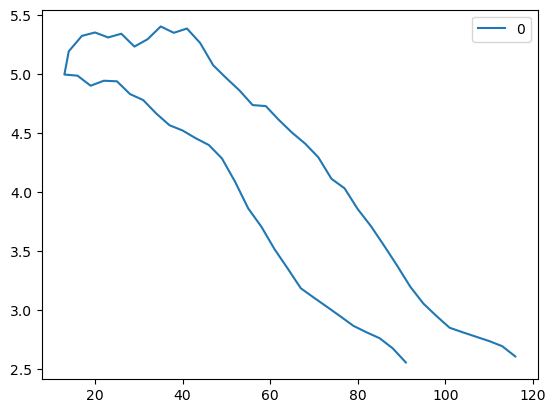

In [439]:
# Plot a curve with values smoothed
ser.rolling(10).mean().plot()

In [255]:
backbone_scores.shape, a_scores.shape, curr_b_scores.shape, curr_ab_scores.shape

((60, 2), (60, 2), (60, 2), (60, 2))

In [285]:
ets_consensus, srebp_consensus

('ACCGGAAGT', 'ATCACGCGAC')

In [284]:
random_backbones[0][:motif_a_start + motif_a_len], a_seqs[0][:motif_a_start + motif_a_len], curr_b_seqs[0][:motif_a_start + motif_a_len], curr_ab_seqs[0][:motif_a_start+motif_a_len]

('AGACGCCGCCGATCGTACCGTAGCAGAGACCAGAGTAATGAAAATCAATAATTCCATTGTATAACCTGAGTAATTTGTCTGGTAATATAAGACCTTATAAGGGTAGCCTGTTACGAGCTTCTGTTTCCA',
 'AGACGCCGCCGATCGTACCGTAGCAGAGACCAGAGTAATGAAAATCAATAATTCCATTGTATAACCTGAGTAATTTGTCTGGTAATATAAGACCTTATAAGGGTAGCCTGTTACGAGCTTACCGGAAGT',
 'ATCACGCGACGATCGTACCGTAGCAGAGACCAGAGTAATGAAAATCAATAATTCCATTGTATAACCTGAGTAATTTGTCTGGTAATATAAGACCTTATAAGGGTAGCCTGTTACGAGCTTCTGTTTCCA',
 'ATCACGCGACGATCGTACCGTAGCAGAGACCAGAGTAATGAAAATCAATAATTCCATTGTATAACCTGAGTAATTTGTCTGGTAATATAAGACCTTATAAGGGTAGCCTGTTACGAGCTTACCGGAAGT')

In [293]:
backbone_exp = np.exp2(backbone_scores)
a_exp = np.exp2(a_scores)
curr_b_exp = np.exp2(curr_b_scores)
curr_ab_exp = np.exp2(curr_ab_scores)

In [294]:
a_scores[0], curr_b_scores[0], backbone_scores[0]

(array([-0.8209674, -0.8858776], dtype=float32),
 array([-0.8567523 , -0.42963225], dtype=float32),
 array([-1.0102847, -1.2531915], dtype=float32))

In [295]:
a_exp[0], curr_b_exp[0], backbone_exp[0]

(array([0.5660623 , 0.54115826], dtype=float32),
 array([0.55219424, 0.742451  ], dtype=float32),
 array([0.49644828, 0.41951913], dtype=float32))

In [297]:
fold_change = curr_ab_exp / denom

In [300]:
np.median(fold_change, axis=0)

array([1.3215151, 1.0671124], dtype=float32)

## Plot